# Runtime Regression

## Preliminaries and Utils

In [1]:
# !pip install seaborn
# !pip install sortedcontainers
# !pip install matplotlib
# !pip install scipy
# !pip install pandas
# !pip install scikit-learn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
import warnings

from datetime import datetime
from sklearn.metrics import accuracy_score, classification_report, f1_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier

from modules.prediction_models import NAGPolynomialRegressor
from modules.prediction_models import RidgePolynomialRegressor

from modules.utils import PrintSummary, ShowPlots

In [3]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [4]:
summary = PrintSummary()
plots = ShowPlots()

In [5]:
def convert_to_hms(time_value, unit="seconds"):
    if unit == "minutes":
        time_value *= 60  # Convert minutes to seconds
    hours, remainder = divmod(time_value, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

## Data Loading

In [6]:
data = 'mx100/job_data_full.parquet'

In [7]:
df = pd.read_parquet(data, engine="pyarrow").copy()

In [8]:
df

,Job Number,User ID,Requested Number of Nodes,Requested Number of CPU,Requested Number of GPU,Total Requested Memory,Desired QoS,Requested Time,Run Time,Duration (H4),...,Jobs Currently Running,Longest Current Running Time,Sum Current Running Times,Occupied Resources,Break Time,Submit Time,Time of Day Cos,Time of Day Sin,Time of Week Cos,Time of Week Sin
103479,2915043,3,1,1,4,0.000977,1,60000,11,Short,...,0,11,11,1,0.0,6250530,-0.557383,0.830256,-0.508344,0.861154
193669,4219784,3,1,32,4,1.843750,1,6000,4871,Medium,...,0,0,0,0,6918363.0,13168893,-0.869387,0.494132,0.149998,-0.988686
191053,6017635,3,1,128,4,29.625000,1,18000,16146,Long,...,0,0,0,0,4975.0,13173868,-0.988005,0.154423,0.200874,-0.979617
203126,4507858,3,1,32,4,1.843750,1,6000,113,Short,...,0,0,0,0,318004.0,13491872,0.557262,0.830337,-0.356350,0.934353
122293,1370469,4,1,128,4,29.625000,1,86400,1015,Medium,...,0,1015,1015,1,0.0,8576653,-0.105469,0.994423,0.420235,0.907415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94488,1440681,1743,8,1024,32,1024.000000,1,1800,255,Short,...,0,0,0,0,275.0,6519465,-0.963338,0.268289,0.184533,-0.982826
73387,3202399,1743,8,1024,32,1024.000000,1,1800,209,Short,...,0,209,209,8,338311.0,6857776,-0.695495,0.718531,-0.530060,0.847960
73586,2422631,1743,8,1024,32,1024.000000,1,1800,52,Short,...,0,52,52,8,6032.0,6863808,-0.934826,0.355107,-0.582123,0.813101
100042,5739891,1743,8,1024,32,1024.000000,1,1800,31,Short,...,0,31,31,8,263099.0,7126907,-0.996843,0.079402,0.211436,-0.977392


In [9]:
useful_columns = ['Job Number', 'User ID', 'Submit Time', 'Run Time', 'Requested Time', 'Duration (H7)', 'Duration (H4)']

In [10]:
# Keep only the necessary columns
df = df[useful_columns]

## Data Inspection

In [11]:
df.describe()

,Job Number,User ID,Submit Time,Run Time,Requested Time
count,2.225200e+05,222520.000000,2.225200e+05,222520.000000,222520.000000
mean,3.122226e+06,660.002948,8.034032e+06,5019.693497,42997.219306
std,1.801406e+06,573.692732,4.165290e+06,14967.141060,38085.279285
min,5.000000e+00,3.000000,0.000000e+00,1.000000,60.000000
25%,1.562478e+06,182.000000,4.279619e+06,11.000000,3600.000000
50%,3.121314e+06,553.000000,8.836398e+06,183.000000,32400.000000
75%,4.685078e+06,1219.000000,1.221116e+07,1704.000000,86400.000000
max,6.242697e+06,1743.000000,1.383493e+07,86395.000000,86400.000000


## Heuristic Runtime Prediction

In [12]:
# Initialize structures to compute rolling average
user_runtime_sum = {}
user_job_count = {}

heuristic_runtimes = []

# Iterate over rows to compute heuristic runtime
for idx, row in df.iterrows():
    user_id = row['User ID']

    # If user has history, compute average
    if user_id in user_runtime_sum and user_job_count[user_id] > 0:
        heuristic_runtime = user_runtime_sum[user_id] / user_job_count[user_id]
    else:
        heuristic_runtime = row['Run Time']  # fallback: actual runtime (or could use expected duration)

    heuristic_runtimes.append(heuristic_runtime)

    # Update history with current job's actual runtime
    user_runtime_sum[user_id] = user_runtime_sum.get(user_id, 0) + row['Run Time']
    user_job_count[user_id] = user_job_count.get(user_id, 0) + 1

# Add the new column
df['Heuristic Run Time'] = heuristic_runtimes

# Split back train and test datasets
df = df.sort_values(by="Submit Time")
split_index = int(len(df) * 0.7)
df_train = df.iloc[:split_index]
df_test = df.iloc[split_index:]

# Compute average prediction error on test set
df_test['Absolute Error'] = np.abs(df_test['Heuristic Run Time'].round() - df_test['Run Time'])
mean_abs_error = df_test['Absolute Error'].mean()

### Analysis

In [13]:
print(f"Mean Absolute Error (Heuristic Predictor on Test Set): {mean_abs_error:.2f}")
print()
print(f"Average prediction error (hh:mm:ss)  :  {convert_to_hms(int(mean_abs_error))}")

Mean Absolute Error (Heuristic Predictor on Test Set): 3844.54

Average prediction error (hh:mm:ss)  :  01:04:04


In [14]:
analysis = df_test[['Job Number', 'Requested Time', 'Run Time']]
analysis['Predicted Runtime'] = df_test['Heuristic Run Time'].round()
analysis.columns = ['Job_ID', 'Requested_Runtime', 'Actual_Runtime', 'Predicted_Runtime']

In [15]:
analysis

,Job_ID,Requested_Runtime,Actual_Runtime,Predicted_Runtime
176934,2265238,14400,4444,1579.0
177603,633622,14400,4213,1586.0
176962,5064447,14400,4649,1579.0
177416,2968257,14400,2800,1584.0
176996,1952764,14400,4629,1580.0
...,...,...,...,...
218553,3214055,300,4,325.0
218614,558069,300,2,325.0
218556,1997479,300,3,325.0
218588,4424415,300,3,325.0


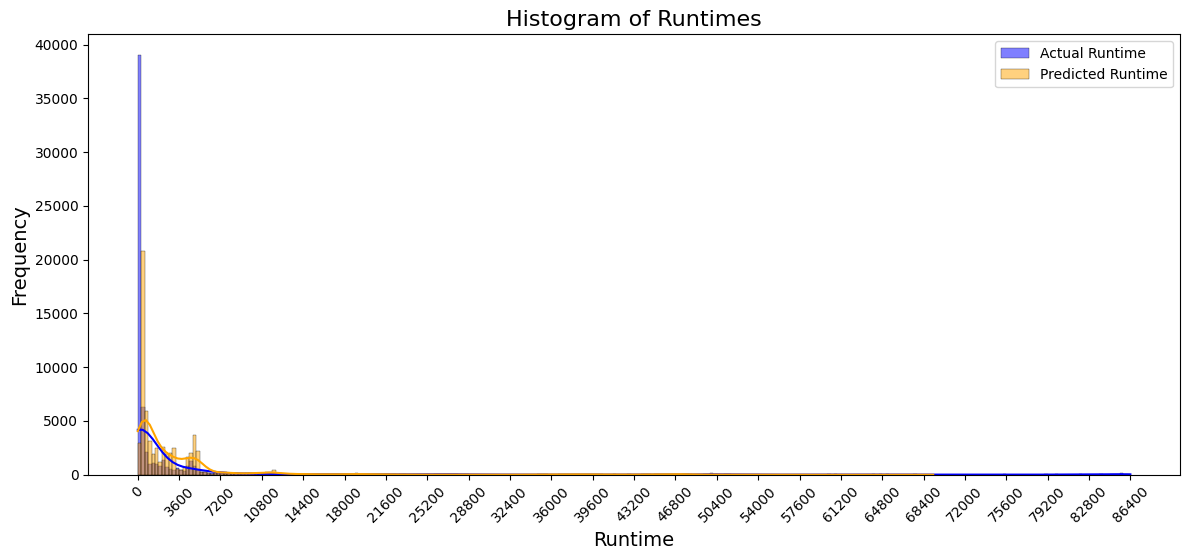

In [16]:
plots.show_runtime_histogram(analysis['Actual_Runtime'], analysis['Predicted_Runtime'], "Actual Runtime", "Predicted Runtime")

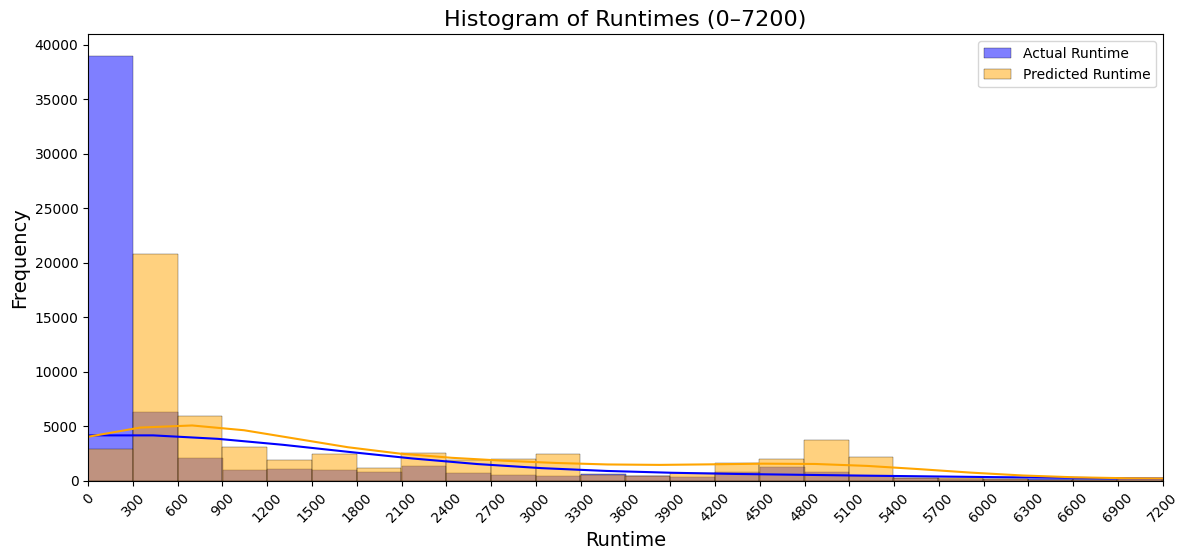

In [17]:
plots.show_runtime_histogram_limited(analysis['Actual_Runtime'], analysis['Predicted_Runtime'], "Actual Runtime", "Predicted Runtime")

In [18]:
print(f"Number of unique predicted runtimes: {analysis['Predicted_Runtime'].nunique()}")

Number of unique predicted runtimes: 11841


## Heuristic Duration Prediction - 7 Classes

In [19]:
# Define category bins (7 classes)
bins = [0, 10, 200, 2000, 6000, 20000, 50000, float('inf')]
labels = ["Very-Short", "Short", "Medium-Short", "Medium", "Medium-Long", "Long", "Very-Long"]

# Create a new column with categories
df_test["Requested Duration (H7)"] = pd.cut(df_test["Requested Time"], bins=bins, labels=labels, right=False)

In [20]:
# Class label mapping
class_map = {
    "Very-Short": 0, "Short": 1, "Medium-Short": 2, "Medium": 3, "Medium-Long": 4, "Long": 5, "Very-Long": 6
}

reverse_class_map = {v: k for k, v in class_map.items()}

# Prepare data
train_df = df_train.copy()
test_df = df_test.copy()

# Map duration classes to integers
train_df['duration_class_encoded'] = train_df['Duration (H7)'].map(class_map).astype('Int64')
test_df['duration_class_encoded'] = test_df['Duration (H7)'].map(class_map).astype('Int64')

# Initialize history from training data
user_class_sum = train_df.groupby('User ID')['duration_class_encoded'].sum().to_dict()
user_class_count = train_df.groupby('User ID')['duration_class_encoded'].count().to_dict()

# Predict and update online
predicted_classes = []

for idx, row in test_df.iterrows():
    user_id = row['User ID']
    actual_class = row['duration_class_encoded']

    # Predict class
    if user_id in user_class_sum and user_class_count[user_id] > 0:
        avg_class = user_class_sum[user_id] / user_class_count[user_id]
        predicted_class = int(round(avg_class))
        predicted_class = np.clip(predicted_class, 0, 3)  # Ensure valid class
    else:
        # Fallback: use requested duration to guess class
        req_dur = row['Requested Time']
        if req_dur <= 10:
            predicted_class = 0  # Very-Short
        elif req_dur <= 200:
            predicted_class = 1  # Short
        elif req_dur <= 2000:
            predicted_class = 2  # Medium-Short
        elif req_dur <= 6000:
            predicted_class = 3  # Medium
        elif req_dur <= 20000:
            predicted_class = 4  # Medium-Long
        elif req_dur <= 50000:
            predicted_class = 5  # Long
        else:
            predicted_class = 6  # Very-Long

    predicted_classes.append(predicted_class)
    
    # Update history with actual class
    user_class_sum[user_id] = user_class_sum.get(user_id, 0) + actual_class
    user_class_count[user_id] = user_class_count.get(user_id, 0) + 1

# Evaluate
true_classes = test_df['duration_class_encoded'].tolist()

accuracy = accuracy_score(true_classes, predicted_classes)
f1_micro = f1_score(true_classes, predicted_classes, average='micro')
f1_macro = f1_score(true_classes, predicted_classes, average='macro')

print("Heuristic Duration Prediction (7 Classes)")
print(f"Accuracy:   {accuracy:.4f}")
print(f"F1-Micro:   {f1_micro:.4f}")
print(f"F1-Macro:   {f1_macro:.4f}")

Heuristic Duration Prediction (7 Classes)
Accuracy:   0.6730
F1-Micro:   0.6730
F1-Macro:   0.3329


In [21]:
# True and predicted classes
true_7 = test_df['Duration (H7)']
pred_7 = test_df['Requested Duration (H7)']

# Metrics
acc4 = accuracy_score(true_7, pred_7)
f1_micro_7 = f1_score(true_7, pred_7, average='micro')
f1_macro_7 = f1_score(true_7, pred_7, average='macro')

print("Requested Duration Prediction (7 Classes)")
print(f"Accuracy:    {acc4:.4f}")
print(f"F1 (Micro):  {f1_micro_7:.4f}")
print(f"F1 (Macro):  {f1_macro_7:.4f}")

Requested Duration Prediction (7 Classes)
Accuracy:    0.0980
F1 (Micro):  0.0980
F1 (Macro):  0.0961


## Heuristic Duration Prediction - 4 Classes

In [22]:
# Define category bins (4 classes)
bins = [0, 10, 300, 7200, float('inf')]
labels = ["Very-Short", "Short", "Medium", "Long"]

# Create a new column with categories
df_test["Requested Duration (H4)"] = pd.cut(df_test["Requested Time"], bins=bins, labels=labels, right=False)

In [23]:
# 1. Class label mapping
class_map = {
    'Very-Short': 0,
    'Short': 1,
    'Medium': 2,
    'Long': 3
}
reverse_class_map = {v: k for k, v in class_map.items()}

# 2. Prepare data
train_df = df_train.copy()
test_df = df_test.copy()

# Map duration classes to integers
train_df['duration_class_encoded'] = train_df['Duration (H4)'].map(class_map).astype('Int64')
test_df['duration_class_encoded'] = test_df['Duration (H4)'].map(class_map).astype('Int64')

# 3. Initialize history from training data
user_class_sum = train_df.groupby('User ID')['duration_class_encoded'].sum().to_dict()
user_class_count = train_df.groupby('User ID')['duration_class_encoded'].count().to_dict()

# 4. Predict and update online
predicted_classes = []

for idx, row in test_df.iterrows():
    user_id = row['User ID']
    actual_class = row['duration_class_encoded']

    # Predict class
    if user_id in user_class_sum and user_class_count[user_id] > 0:
        avg_class = user_class_sum[user_id] / user_class_count[user_id]
        predicted_class = int(round(avg_class))
        predicted_class = np.clip(predicted_class, 0, 3)  # Ensure valid class
    else:
        # Fallback: use requested duration to guess class
        req_dur = row['Requested Time']
        if req_dur <= 300:
            predicted_class = 0  # Very-Short
        elif req_dur <= 1800:
            predicted_class = 1  # Short
        elif req_dur <= 7200:
            predicted_class = 2  # Medium
        else:
            predicted_class = 3  # Long

    predicted_classes.append(predicted_class)

    # Update history with actual class
    user_class_sum[user_id] = user_class_sum.get(user_id, 0) + actual_class
    user_class_count[user_id] = user_class_count.get(user_id, 0) + 1

# 5. Evaluate
true_classes = test_df['duration_class_encoded'].tolist()

accuracy = accuracy_score(true_classes, predicted_classes)
f1_micro = f1_score(true_classes, predicted_classes, average='micro')
f1_macro = f1_score(true_classes, predicted_classes, average='macro')

print("Heuristic Duration Prediction (4 Classes)")
print(f"Accuracy:   {accuracy:.4f}")
print(f"F1-Micro:   {f1_micro:.4f}")
print(f"F1-Macro:   {f1_macro:.4f}")

Heuristic Duration Prediction (4 Classes)
Accuracy:   0.7595
F1-Micro:   0.7595
F1-Macro:   0.5819


In [24]:
# True and predicted classes
true_4 = test_df['Duration (H4)']
pred_4 = test_df['Requested Duration (H4)']

# Metrics
acc4 = accuracy_score(true_4, pred_4)
f1_micro_4 = f1_score(true_4, pred_4, average='micro')
f1_macro_4 = f1_score(true_4, pred_4, average='macro')

print("Requested Duration Prediction (4 Classes)")
print(f"Accuracy:    {acc4:.4f}")
print(f"F1 (Micro):  {f1_micro_4:.4f}")
print(f"F1 (Macro):  {f1_macro_4:.4f}")

Requested Duration Prediction (4 Classes)
Accuracy:    0.1590
F1 (Micro):  0.1590
F1 (Macro):  0.1266
